# Extrusion force



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors
from utils import *

In [91]:
data_folder = Path(r"G:\Zhengyang\2025-09-16")
filename = "测试2025.09.16--10-57-s-240.xls"
data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")
interval = 0.1

## 1 Time series

Text(0, 0.5, 'Velocity (mm/s)')

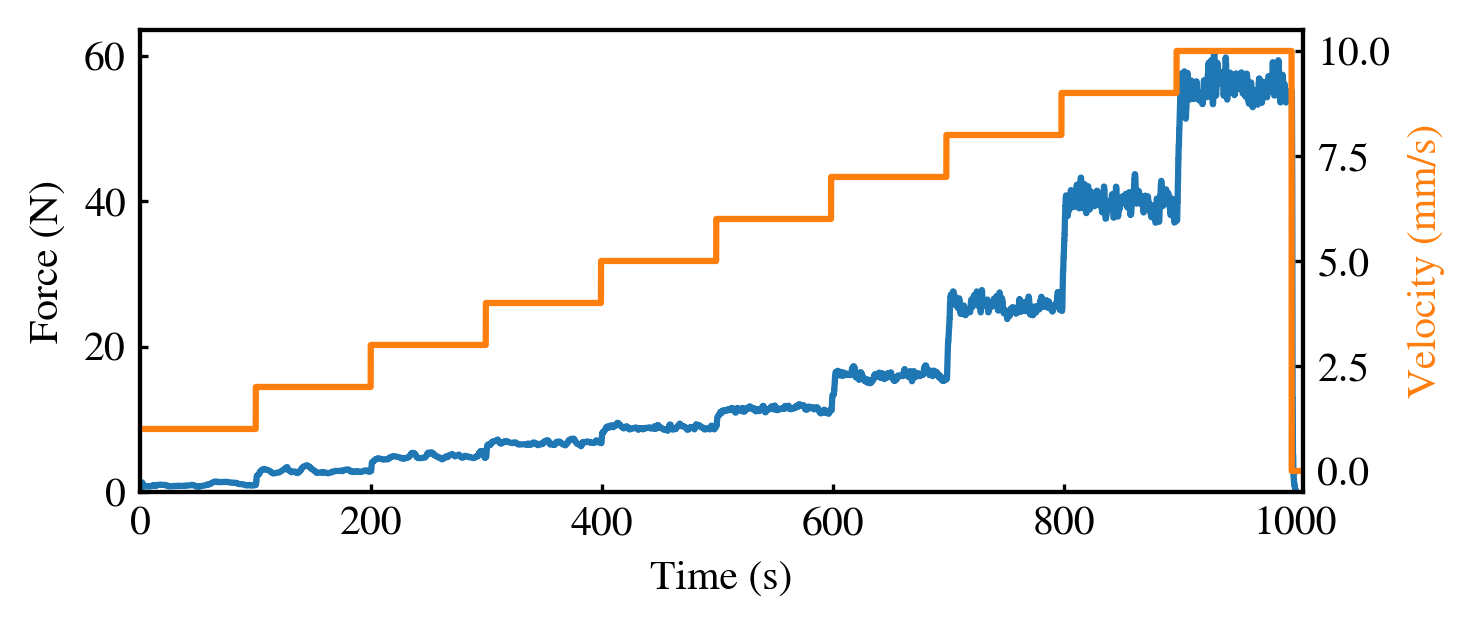

In [95]:
t = data.index * interval
force = data["压力 kg"] * 9.8
velocity = data["当前速度值 mm/s"]
plt.figure(figsize=(5, 2))
plt.plot(t, force)
plt.xlim(0, t.max())
plt.ylim(0, force.max() * 1.05)
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(t, velocity, color="C1")
ax1.set_ylabel("Velocity (mm/s)", color="C1")

## 2 Separate based on extruder velocity

In [80]:
len(g)

996

In [78]:
ind

np.int64(512)

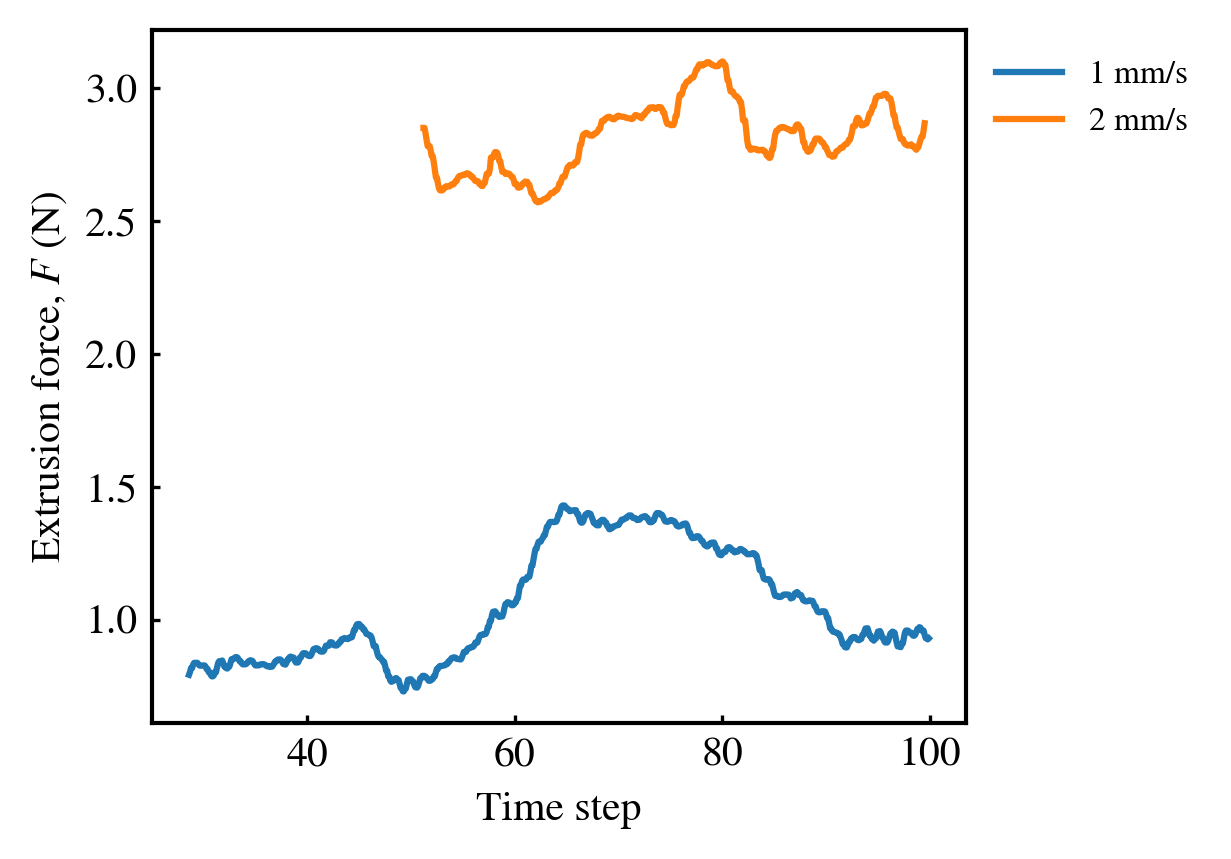

In [75]:
v_list = []
fmean_list = []
fstd_list = []
for v, g in data.groupby("当前速度值 mm/s"):
    if v == 0 or v > 8:
        continue
    ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
    if ind is not None:
        t = np.arange(len(g))[ind:] * interval
        force = g["压力 kg"].iloc[ind:] * 9.8
        plt.plot(t, force, label=f"{v} mm/s")
        v_list.append(v)
        fmean_list.append(force.iloc[ind:].mean())
        fstd_list.append(force.iloc[ind:].std())
    if v == 2:
        break
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")
plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))

## 3 Critical extruder velocity

In [76]:
df = pd.DataFrame({"速度": v_list, "挤出力": fmean_list, "挤出力标准差": fstd_list})

In [77]:
df

,速度,挤出力,挤出力标准差
0,1,1.180096,0.17719
1,2,NaN,NaN


In [64]:
# find transition extruder velocity
transition_velocity = find_force_transition_velocity(df, thres=0.02) # this threshold value may be correlated with the experimental noise level

plt.errorbar(v_list, fmean_list, yerr=fstd_list, marker="o", ls="")
plt.axvline(transition_velocity, color="C3", ls="--", label=f"Transition velocity: {transition_velocity:.2f} mm/s")
plt.xlabel("Extruder velocity, $v$ (mm/s)")
plt.ylabel("Mean extrusion force, $F$ (N)")
plt.xlim(0, max(v_list) * 1.05)
plt.ylim(0, max(fmean_list) * 1.05)

ValueError: array must not contain infs or NaNs

## 4 Process multiple datasets

In [82]:
data_folder = Path(r"G:\Zhengyang\2025-09-16")
filenames = {
    200 : "测试2025.09.16--11-15-s-200.xls",
    210 : "测试2025.09.16--10-04-s-210.xls",
    220 : "测试2025.09.16--10-20-s-220.xls",
    230 : "测试2025.09.16--10-38-s-230.xls",
    # 240 : "测试2025.09.16--10-57-s-240.xls"
}
interval = 0.1


In [83]:
dfs = []
for T in filenames:
    filename = filenames[T]
    data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")
    v_list = []
    fmean_list = []
    fstd_list = []
    for v, g in data.groupby("当前速度值 mm/s"):
        if v == 0:
            continue
        ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
        if ind is not None:
            t = np.arange(len(g))[ind:] * interval
            force = g["压力 kg"].iloc[ind:] * 9.8
            v_list.append(v)
            fmean_list.append(force.iloc[ind:].mean())
            fstd_list.append(force.iloc[ind:].std())
    df = pd.DataFrame({"速度": v_list, "挤出力": fmean_list, "挤出力标准差": fstd_list, "温度": T})
    dfs.append(df)

200 5.575757575757576
210 6.181818181818182
220 6.454545454545455
230 6.818181818181818


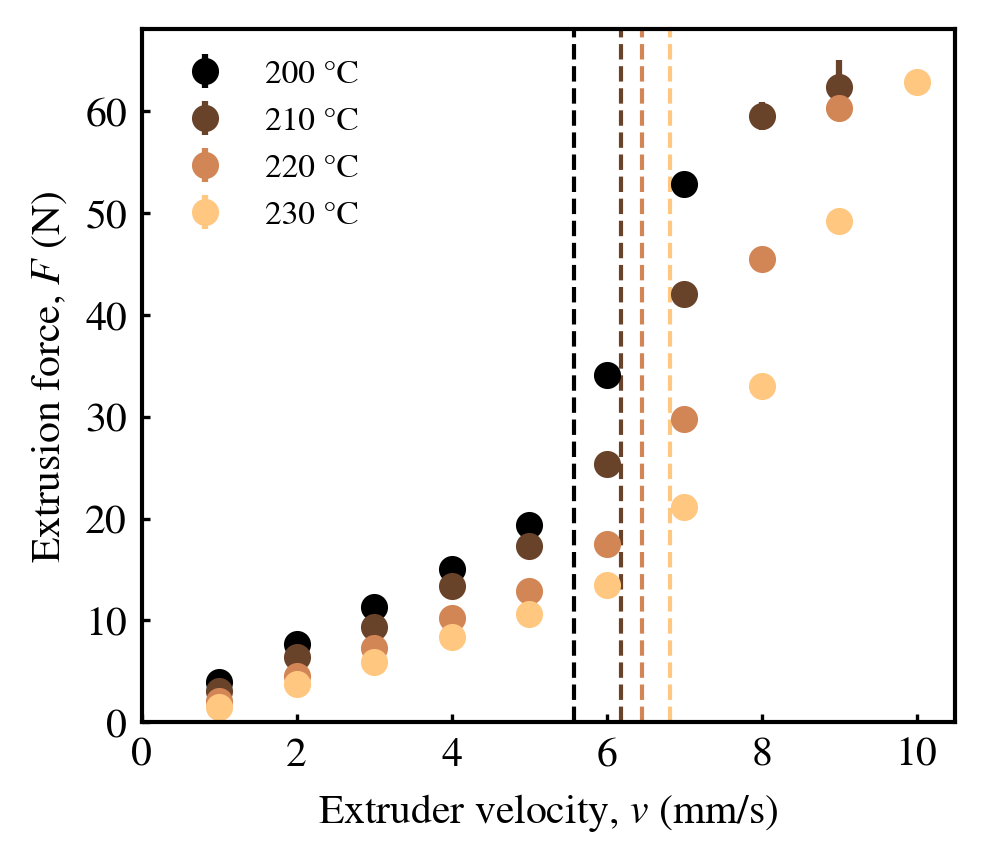

In [90]:
cmap = plt.get_cmap("copper", 4)
for i, df in enumerate(dfs):
    color = cmap(i)
    velocity = df["速度"]
    force = df["挤出力"]
    force_std = df["挤出力标准差"]
    T = df['温度'].iloc[0]
    transition_velocity = find_force_transition_velocity(df, thres=0.02)
    plt.errorbar(velocity, force, yerr=force_std, color=color, marker="o", ls="", label=f"{T} °C")
    plt.axvline(transition_velocity, color=color, ls="--", lw=1)
    print(T, transition_velocity)
plt.xlabel("Extruder velocity, $v$ (mm/s)")
plt.ylabel("Extrusion force, $F$ (N)")
plt.xlim(0, 10.5)
plt.ylim(0, 68)
plt.legend(fontsize=8, loc="upper left")


In [49]:
g["压力 kg"].iloc[ind:]

228     0.3969
229     0.3971
230     0.3980
231     0.3980
232     0.4003
         ...  
1096    0.3861
1097    0.3863
1098    0.3863
1099    0.3863
1100    0.3856
Name: 压力 kg, Length: 873, dtype: object

In [50]:
T

200